# Comparing PhyloPart, ClusterPicker and Phydelity (HBV Vietnam)

This jupyter notebook performs clustering analyses using PhyloPart and ClustePicker and compares the results with Phydelity output clusters. Note that there are both Python and R codes in this notebook. 

## Import Python modules and libraries

In [1]:
from __future__ import division
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import csv 
import ete3
import re
import subprocess
import itertools 
import random 
import string

## Parameters 

Note that a range of genetic distance thresholds will be evaluated - ClusterPicker: 0.005-0.1 substitutions/site; PhyloPart: 0.5-10 percentile of global patristic distance distribution. 

In [2]:
thresholds = np.arange(0.005, 0.101, 0.001) # genetic distance threshold range 
treefile = "./RAxML_bipartitions.HBV_Viet_bestBS_rooted_ft.newick" # ML tree generated from RAxML
fastafile = "./HBV_alignment.fasta" # FASTA alignment
phydelity_clstrfile = "./cluster_phydelity_k5_sol0_RAxML_bestTree.txt" # phydelity cluster file

# path to jarfile for PhyloPart and ClusterPicker --> CHANGE THIS AS NECESSARY 
phylopart_jarfile = "/home/alvin/Dropbox/softwares/PhyloPart_v2.1/PhyloPart_v2.1.jar" 
clusterpicker_jarfile = "/home/alvin/Dropbox/softwares/ClusterPicker_1.2.3.jar"

## Run PhyloPart and ClusterPicker

In [3]:
try: 
    phylopart_df = pd.read_csv("./phylopart_HBV_results.csv")
    run_phylopart = 0
except:
    phylopart_df = {"cluster":[], "leaf":[], "threshold":[]}
    run_phylopart = 1
    
try: 
    clusterpicker_df = pd.read_csv("./clusterpicker_HBV_results.csv")
    run_clusterpicker = 0
except: 
    clusterpicker_df = {"cluster":[], "leaf":[], "threshold":[]}
    run_clusterpicker = 1
    
for t in thresholds:
    
    if run_phylopart == 1:
        # Run PhyloPart 
        outfname = "./ppOUT.csv" # output filename 
        # run PhyloPart with current threshold 
        cmd = ["java", "-Xss2m", "-jar", phylopart_jarfile, treefile, str(t), "-b0", "-o{}".format(outfname)]
        subprocess.call(cmd)

        # read output file 
        with open(outfname, "rb") as fhandle:
            for l, line in enumerate(csv.reader(fhandle)):
                if l == 0:
                    continue 

                cluster, leaf = int(line[0]), line[2].upper()
                if cluster == 0:
                    continue 

                # save cluster, leafname and threshold into dataframe
                phylopart_df["cluster"].append(cluster)
                phylopart_df["leaf"].append(leaf)
                phylopart_df["threshold"].append(t)
    
    if run_clusterpicker == 1:
        # Run ClusterPicker 
        outfname = "{}_clusterPicks_log.txt".format(re.sub("\.[^\.]+$", "", treefile))
        cmd = ["java", "-Xss2m", "-jar", clusterpicker_jarfile, fastafile, treefile, "0", "0", str(t)]
        subprocess.call(cmd)

        # read output file 
        with open(outfname, "rb") as fhandle:
            for l, line in enumerate(reversed(list(csv.reader(fhandle, delimiter="\t")))):
                if l == 0:
                    continue 
                if line[0] == "ClusterNumber":
                    break 

                cluster, clustered_leaves = line[0], line[3]
                for leaf in re.sub("(\[|\])", "", clustered_leaves).split(", "):
                    leaf = leaf.upper()
                    clusterpicker_df["cluster"].append(int(cluster))
                    clusterpicker_df["leaf"].append(leaf)
                    clusterpicker_df["threshold"].append(t)

if run_phylopart == 1:
    phylopart_df = pd.DataFrame(phylopart_df)
    phylopart_df.to_csv("phylopart_HBV_results.csv", index=False)

if run_clusterpicker == 1:
    clusterpicker_df = pd.DataFrame(clusterpicker_df)
    clusterpicker_df.to_csv("clusterpicker_HBV_results.csv", index=False)

# PhyloPart
phylopart_df.head()

,cluster,leaf,threshold
0,216,292-VIET13_F3,0.005
1,216,771-VIET12,0.005
2,225,351-VIET12,0.005
3,225,289-VIET13_F3,0.005
4,276,316-VIET13_F4,0.005


In [4]:
# ClusterPicker
clusterpicker_df.head()

,cluster,leaf,threshold
0,5,316-VIET13_F4,0.005
1,5,313-VIET13_F4,0.005
2,4,591-VIET12,0.005
3,4,277-VIET13_F2,0.005
4,3,298-VIET13_F3,0.005


## Calculate mean Silhouette index

We use mean Silhouette index (which measures the ratio of similarity for items within its own cluster to its nearest neighbours) as an optimality criterion to find the "optimal" threshold parameter.

In [5]:
# read tree file using ete3
tree = ete3.Tree(treefile)
leaves = [_ for _ in tree.get_leaves()  if _.name != "X75663_Brazil_F"] # all leaf nodes except outgroup (X75663)
all_leaf_names = [_.name.upper() for _ in leaves] # all leaf names 
N = len(all_leaf_names)

# get array of inter-leaf distances 
X = np.zeros((N, N))
for i, j in itertools.combinations(range(N), 2):
    X[(i,j)] = X[(j,i)] = leaves[i].get_distance(leaves[j])

# get silhouette index (SI)
def get_SI(df, t, s=0):
    # filter dataframe based on threshold 
    fildf = df[df["threshold"] == t]
    
    if len(fildf) == 0:
        return 0.
    
    # get set of unique clusters 
    cluster_set = list(set(fildf.cluster))
    
    labels_pred = [] # cluster labels 
    for leaf in all_leaf_names: 
        if leaf in list(fildf.leaf):
            # for leaves that were clustered, append its cluster label to labels_pred
            cluster = fildf[fildf.leaf == leaf]["cluster"].iloc[0]
        else: 
            # for unclustered leaves, they will just have a unique cluster label each 
            cluster = random.choice(list(set(range(1000)) - set(cluster_set)))
            cluster_set.append(cluster)
        
        labels_pred.append(cluster)
    
    if len(set(labels_pred)) == 1:
        return np.nan

    return silhouette_score(X, labels_pred)
    
# for each threshold
pp_SI = np.zeros(len(thresholds)) # phylopart SI
cp_SI = np.zeros(len(thresholds)) # clusterpicker SI

for _t, t in enumerate(thresholds): 
    # First, we analyse results from PhyloPart 
    pp_SI[_t] = get_SI(phylopart_df, t)
    
    # Repeat for ClusterPicker 
    cp_SI[_t] = get_SI(clusterpicker_df, t, 1)

## Plot threshold range against SI 

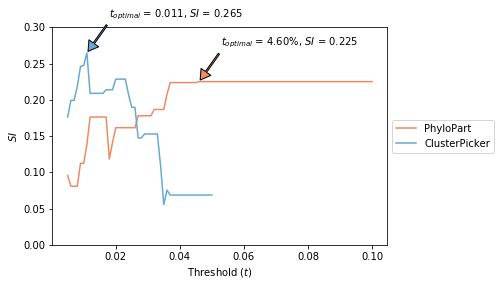

In [6]:
# plot t vs SI 
plt.plot(thresholds, pp_SI, "#ef8a62", label="PhyloPart")
plt.plot(thresholds, cp_SI, "#67a9cf", label="ClusterPicker")
plt.yticks(np.arange(0, 0.31, 0.05))

# annotate max SI
pp_ymax = np.max(pp_SI[~np.isnan(pp_SI)])
pp_xmax = thresholds[list(pp_SI).index(pp_ymax)]
plt.annotate(r'$t_{{optimal}}$ = {:.2%}, $SI$ = {:.3f}'.format(pp_xmax, pp_ymax), xy=(pp_xmax, pp_ymax), xytext=(pp_xmax+0.007, pp_ymax+0.05), 
             arrowprops=dict(facecolor='#ef8a62', width=1.5, headwidth=12, headlength=10, shrink=0.05),)

cp_ymax = np.max(cp_SI[~np.isnan(cp_SI)])
cp_xmax = thresholds[list(cp_SI).index(cp_ymax)]
plt.annotate(r'$t_{{optimal}}$ = {}, $SI$ = {:.3f}'.format(cp_xmax, cp_ymax), xy=(cp_xmax, cp_ymax), xytext=(cp_xmax+0.007, cp_ymax+0.05), 
             arrowprops=dict(facecolor='#67a9cf', width=1.5, headwidth=12, headlength=10, shrink=0.05),)

plt.ylabel("$SI$")
plt.xlabel("Threshold ($t$)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("SI_HBV.pdf",bbox_inches="tight")
plt.show()

## Parse Phydelity clusters

In [7]:
phydelity_df = {"cluster":[], "leaf":[]}
with open(phydelity_clstrfile, "rb") as fhandle:
    for l, line in enumerate(csv.reader(fhandle, delimiter="\t")):
        if l != 0:
            cluster, leaf = line
            phydelity_df["cluster"].append(int(cluster))
            phydelity_df["leaf"].append(leaf.upper())
phydelity_df = pd.DataFrame(phydelity_df)
phydelity_df.head()

,cluster,leaf
0,39,736-VIET12
1,20,351-VIET12
2,7,4061-VIET12
3,74,316-VIET13_F4
4,20,289-VIET13_F3


## Comparing Phydelity to ClusterPicker and PhyloPart

In [8]:
combined_df = {"leaf":["X75663_Brazil_F"], "Phydelity":[""], "ClusterPicker":[""], "PhyloPart":[""]}

for leaf in all_leaf_names:
    # get phydelity cluster 
    try:
        phydelity_cluster = phydelity_df[phydelity_df.leaf == leaf]["cluster"].iloc[0]
    except:
        phydelity_cluster = ""
    # get ClusterPicker cluster
    try:
        cp_cluster = clusterpicker_df[clusterpicker_df.leaf == leaf][clusterpicker_df.threshold == cp_xmax]["cluster"].iloc[0]
    except:
        cp_cluster = ""
    # get PhyloPart cluster 
    try:
        pp_cluster = phylopart_df[phylopart_df.leaf == leaf][phylopart_df.threshold == pp_xmax]["cluster"].iloc[0]
    except:
        pp_cluster = ""
        
    combined_df["leaf"].append(leaf)
    combined_df["Phydelity"].append(phydelity_cluster)
    combined_df["ClusterPicker"].append(cp_cluster)
    combined_df["PhyloPart"].append(pp_cluster)

combined_df = pd.DataFrame(combined_df)

# Make cluster indices unique across all three methods if possible (based on Phydelity index)
# First, make sure indices are unique across the three methods 
all_ci = filter(None, set(combined_df.Phydelity)|set(combined_df.ClusterPicker)|set(combined_df.PhyloPart))

common_indices = set(filter(None, combined_df.Phydelity))&set(filter(None, combined_df.ClusterPicker))
if common_indices: 
    for ci in common_indices:
        replaced_ci = random.choice(list(set(range(10000)) - set(all_ci)))
        all_ci.append(replaced_ci)
        for _ in combined_df[combined_df["ClusterPicker"] == ci].index.values:
            combined_df.at[_, "ClusterPicker"] = replaced_ci

# Map CP and PP clusters to Phydelity 
for col in combined_df:
    if col == "leaf" or col == "Phydelity":
        continue 
    
    for ci in filter(None, set(combined_df[col])):
        phydelity_eq_ci = list(set(combined_df[combined_df[col] == ci]["Phydelity"]))
        if len(phydelity_eq_ci) == 1: # only one phydelity eq cluster 
            phydelity_eq_ci = phydelity_eq_ci[0]
            # check that the same tips are clustered 
            if set(combined_df[combined_df[col] == ci]["leaf"]) == set(combined_df[combined_df["Phydelity"] == phydelity_eq_ci]["leaf"]):
                # change col cluster to phydelity eq cluster 
                for _ in combined_df[combined_df[col] == ci].index.values:
                    combined_df.at[_, col] = phydelity_eq_ci

#  get CP and PP clusters unique to Phydelity 
cp_clusters = filter(None, set(combined_df["ClusterPicker"]))
pp_clusters = filter(None, set(combined_df["PhyloPart"]))
phydelity_clusters = filter(None, set(combined_df["Phydelity"]))
for cp_ci, pp_ci in itertools.product(cp_clusters, pp_clusters):
    if cp_ci in phydelity_clusters or pp_ci in phydelity_clusters:
        continue 
    else: 
        if set(combined_df[combined_df["ClusterPicker"] == cp_ci]["leaf"]) == set(combined_df[combined_df["PhyloPart"] == pp_ci]["leaf"]):
            # change CP cluster to PP eq cluster 
            for _ in combined_df[combined_df["ClusterPicker"] == cp_ci].index.values:
                combined_df.at[_, "ClusterPicker"] = pp_ci
                    
# re-order columns 
combined_df = combined_df[["leaf", "Phydelity", "ClusterPicker", "PhyloPart"]]
combined_df

/home/alvin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/alvin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,leaf,Phydelity,ClusterPicker,PhyloPart
0,X75663_Brazil_F,,,
1,4268-VIET12,,,
2,4505-VIET12,,,
3,4454-VIET12,7,7,7
4,4517-VIET12,7,7,7
5,4061-VIET12,7,7,7
6,4280-VIET12,13,13,13
7,4406-VIET12,13,13,13
8,3770-VIET12,13,13,13
9,4445-VIET12,13,13,13
